# Open nested combat: TOP and StrokeMRI open nested-harmonized datasets

Note this must be run in the `opnc` environment

## import libraries

In [1]:
import os
import sys
from itertools import permutations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

import neuroCombat as nC
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from scipy.stats import ranksums, ttest_ind, ttest_rel, ks_2samp, anderson_ksamp

sys.path.insert(0, '../') # path to cvasl functions
import cvasl.seperated as sep

## Read in our data

In [2]:
filepath = '../open_work/internal_results/cleaned_pvc2s/' 
filename_mri = os.path.join(filepath,'StrokeMRI_pvc2c.csv') 
filename_top = os.path.join(filepath,'TOP_pvc2c.csv') 

In [3]:
mri = pd.read_csv(filename_mri)
top = pd.read_csv(filename_top)

## Below are functions out of the Hannah Horng Opn-combat library
The library is here https://github.com/hannah-horng/opnested-combat
As the library is unreleased and unversioned, we are using the MIT lisenced functions directly to version control them

In [4]:
# functions from opncombat
def OPNestedComBat(dat, covars, batch_list, filepath, categorical_cols=None, continuous_cols=None, return_estimates=False):
    """
    Completes sequential OPNested ComBat harmonization on an input DataFrame. Order is determined by running through all
    possible permutations of the order, then picking the order with the lowest number of features with significant
    differences in distribution.

    Arguments
    ---------
    dat : DataFrame of original data with shape (features, samples)
    covars : DataFrame with shape (samples, covariates) corresponding to original data. All variables should be label-
        encoded (i.e. strings converted to integer designations)
    batch_list : list of strings indicating batch effect column names within covars (i.e. ['Manufacturer', 'CE'...])
    filepath : root directory path for saving KS test p-values and kernel density plots created during harmonization
    categorical_cols : string or list of strings of categorical variables to adjust for
    continuous_cols : string or list of strings of continuous variables to adjust for
    return_estimates : if True, function will return both output_df and final_estimates

    Returns
    -------
    output_df : DataFrame with shape (features, samples) that has been sequentially harmonized with Nested ComBat
    final_estimates : list of dictionaries of estimates from iterative harmonization, used if user is deriving estimates
        from training data that need to be applied to a separate validation dataset

    """
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    perm_list = list(permutations(np.arange(len(batch_list))))
    count_dict = {}
    feature_dict = {}
    estimate_dict = {}
    c = 0
    for order in perm_list:
        c += 1
        n_dat = dat.copy()
        estimate_list = []
        print('Iteration ' + str(c) + ' of ' + str(len(perm_list)))
        for i in order:
            batch_col = batch_list[i]
            output = nC.neuroCombat(n_dat, covars, batch_col, continuous_cols=continuous_cols,
                                    categorical_cols=categorical_cols)
            output_df = pd.DataFrame.from_records(output['data'].T)
            n_dat = output_df.T
            estimate_list.append(output['estimates'])
        output_df.columns = dat.index
        feature_dict[str(order)] = n_dat
        count_dict[str(order)] = 0
        estimate_dict[str(order)] = estimate_list
        for batch_col in batch_list:
            p_list = []
            # print(batch_col)
            for j in range(len(output_df.columns)):
                feature = output_df.iloc[:, j]
                # print(j)
                split_col = [feature[covars[batch_col] == i] for i in covars[batch_col].unique()]
                p_list.append(anderson_ksamp(split_col).significance_level)
            count_dict[str(order)] += np.sum(np.asarray(p_list) < 0.05)
    if len(batch_list) != 1:
        best_order = [key for key, value in count_dict.items() if value == min(count_dict.values())][0]
        best_order_list = list(map(int, best_order[1:-1].split(', ')))
        order = [batch_list[i] for i in best_order_list]
        n_dat = feature_dict[best_order]
        final_estimate = estimate_dict[best_order] 

    print('Final Order: ' + str(order))

    txt_path = filepath + 'order.txt'
    with open(txt_path, 'w') as f:
        for item in order:
            f.write("%s\n" % item)

    output_df = pd.DataFrame.from_records(n_dat.T)
    output_df.columns = dat.index
    if return_estimates:
        return output_df, final_estimate
    else:
        return output_df


def feature_ad(dat, output_df, covars, batch_list, filepath):
    """
    Computes AD test p-values separated by batch effect groups for a dataset (intended to assess differences in
    distribution to all batch effects in batch_list following harmonization NestedComBat

    Arguments
    ---------
    dat : DataFrame of original data with shape (samples, features)
    output_df: DataFrame of harmonized data with shape (samples, features)
    covars : DataFrame with shape (samples, covariates) corresponding to original data. All variables should be label-
            encoded (i.e. strings converted to integer designations)
    batch_list : list of strings indicating batch effect column names within covars (i.e. ['Manufacturer', 'CE'...])
    filepath : write destination for kernel density plots and p-values

    If a feature is all the same value, the AD test cannot be completed.

    """
    p_df_original = pd.DataFrame()
    p_df_combat = pd.DataFrame()
    for batch_col in batch_list:

        # Computing KS Test P-Values
        p_list_original = []
        p_list_combat = []
        for j in range(len(output_df.columns)):
            feature_original = dat.iloc[:, j]
            feature_combat = output_df.iloc[:, j]
            try:
                split_col_original = [feature_original[covars[batch_col] == i] for i in covars[batch_col].unique()]
                p_list_original.append(anderson_ksamp(split_col_original).significance_level)
                split_col_combat = [feature_combat[covars[batch_col] == i] for i in covars[batch_col].unique()]
                p_list_combat.append(anderson_ksamp(split_col_combat).significance_level)
            except ValueError:
                print('Feature is all same value: ' + output_df.columns[j])

        p_df_original[batch_col] = p_list_original
        p_df_combat[batch_col] = p_list_combat

    p_df_original.index = dat.columns
    p_df_combat.index = output_df.columns
    p_df_original.to_csv(filepath + 'p_values_original.csv')
    p_df_combat.to_csv(filepath + 'p_values_combat.csv')
    

def feature_histograms(dat, output_df, covars, batch_list, filepath):
    """
    Plots kernel density plots and computes KS test p-values separated by batch effect groups for a dataset (intended
    to assess differences in distribution to all batch effects in batch_list following harmonization with
    NestedComBat

    Arguments
    ---------
    dat : DataFrame of original data with shape (samples, features)
    output_df: DataFrame of harmonized data with shape (samples, features)
    covars : DataFrame with shape (samples, covariates) corresponding to original data. All variables should be label-
        encoded (i.e. strings converted to integer designations)
    batch_list : list of strings indicating batch effect column names within covars (i.e. ['Manufacturer', 'CE'...])
    filepath : write destination for kernel density plots and p-values
    ad : KS test for binary batch effects if False, Anderson-Darling test for categorical batch effects if True

    """
    for batch_col in batch_list:
        filepath3 = filepath + batch_col + '/'
        if not os.path.exists(filepath3):
            os.makedirs(filepath3)

        # Plotting Kernel Density Plots
        for col in output_df:
            feature_original = dat[col]
            feature_combat = output_df[col]

            try:

                plt.figure()
                for i in covars[batch_col].unique():
                    feature_original[covars[batch_col] == i].plot.kde(color='r', alpha=0.75)
                for i in covars[batch_col].unique():
                    feature_combat[covars[batch_col] == i].plot.kde(color='b', alpha=0.5)
                    if max(feature_combat[covars[batch_col] == i]) > 1:
                        plt.xlim([0, 200])
                plt.xlabel(col)
                plt.ylabel('Density')
                leg = ['Original', 'ComBat']
                plt.legend(leg)
                ax = plt.gca()
                leg = ax.get_legend()
                leg.legendHandles[0].set_color('r')
                leg.legendHandles[1].set_color('b')

                filename = filepath3 + 'histogram_' + col + ".png"
                plt.savefig(filename, bbox_inches='tight')
                plt.close()
                plt.close('all')
            except np.linalg.linalg.LinAlgError:
                print('Failed to plot: ' + col)


def GMMSplit(dat, caseno, filepath):
    """
    Completes Gaussian Mixture model fitting and ComBat harmonization by the resulting sample grouping. The assumption
    here is that there is an unknown batch effect causing bimodality such that we can estimate the sample groupings for
    this hidden batch effect from the distribution. This function will take in a dataset, determine the best 2-component
    Gaussian mixture model, and use the resulting sample grouping to harmonize the data with ComBat.

    Arguments
    ---------
    dat : DataFrame of original data with shape (features, samples)
    caseno : DataFrame/Series containing sample IDs (should be aligned with dat and covars), used to return sample
        grouping assignments.
    filepath : root directory path for saving the grouping and corresponding kernel density plots
    -------
    new_dat : DataFrame with shape (features, samples) that has been sequentially harmonized with Nested ComBat

    """
    # GENERATING GMM GROUPING
    data_keys = list(dat.T.keys())
    aic_values = []
    predictions = []
    col_list = []
    final_keys = []
    filepath2 = filepath+'GMM_Split/'
    if not os.path.exists(filepath2):
        os.makedirs(filepath2)

    for i in range(len(data_keys)):
        # print(col)
        feature = dat.T.iloc[:, i]
        X = pd.DataFrame({0: feature, 1: feature})
        gmix = GaussianMixture(n_components=2)
        col = data_keys[i]
        try:
            gmix.fit(X)
            results = gmix.predict(X)
            cluster_0 = X[results == 0].iloc[:, 0]
            cluster_1 = X[results == 1].iloc[:, 0]
            # print(len(cluster_0))
            if len(cluster_0) <= .25*len(caseno) or len(cluster_1) <= .25*len(caseno):
                print('Clusters unbalanced: ' + data_keys[i])
            else:
                try:
                    plt.figure()
                    cluster_0.plot.kde()
                    cluster_1.plot.kde()
                    X.iloc[:, 0].plot.kde()
                    plt.legend(['Cluster 0', 'Cluster 1', 'Original'])
                    plt.xlabel(data_keys[i])
                    filename = filepath2 + 'histogram_' + data_keys[i] + ".png"
                    plt.savefig(filename, bbox_inches='tight')
                    plt.close()
                except:
                    plt.close()
                    print('Failed to plot: ' + col)
                final_keys.append(col)
                predictions.append(results)
                aic_values.append(gmix.aic(X))
                col_list.append(col)
        except ValueError:
            print('Failed to fit: ' + col)
            # aic_values.append(np.nan)

    # Returning AIC values
    gaussian_df = pd.DataFrame({'Feature': final_keys, 'AIC': aic_values})
    best_fit = gaussian_df[gaussian_df['AIC'] == min(gaussian_df['AIC'])]['Feature'].iloc[0].strip(' ')
    best_fit_n = gaussian_df[gaussian_df['AIC'] == min(gaussian_df['AIC'])]['Feature'].index[0]
    gaussian_df.to_csv(filepath2 + 'GaussianMixture_aic_values.csv')

    # Returning patient split
    predictions_df = pd.DataFrame()
    predictions_df['Patient'] = caseno
    predictions_df['Grouping'] = predictions[best_fit_n]
    predictions_df.to_csv(filepath2 + best_fit + '_split.csv')

    return predictions_df

In [5]:
top_batch_testing_df = top[['participant_id','age', 'sex']]
top_batch_testing_df['site'] = 1
column_to_move = top_batch_testing_df.pop("site")
top_batch_testing_df.insert(1, "site", column_to_move)
#top_batch_testing_df.head(3)

C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\1670456683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_batch_testing_df['site'] = 1


In [6]:
mri_batch_testing_df = mri[['participant_id','age', 'sex']]
mri_batch_testing_df['site'] = 2
column_to_move = mri_batch_testing_df.pop("site")
mri_batch_testing_df.insert(1, "site", column_to_move)
#mri_batch_testing_df.head(3)

C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\1931166062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mri_batch_testing_df['site'] = 2


In [7]:
batch_testing_df = pd.concat([top_batch_testing_df, mri_batch_testing_df], ignore_index=True)
batch_testing_df = sep.recode_sex_to_numeric(batch_testing_df)
batch_testing_df.tail(5)

,participant_id,site,age,sex
1036,sub-59440_1_ses-1_run-1,2,73.928767,0
1037,sub-59440_2_ses-2_run-1,2,74.769863,0
1038,sub-59441_2_ses-2_run-1,2,74.512329,0
1039,sub-59442_1_ses-1_run-1,2,67.526027,0
1040,sub-59442_2_ses-2_run-1,2,68.410959,0


In [8]:
# Loading in batch effects
batch_testing_list = ['site']
# Loading in clinical covariates
categorical_testing_cols = ['sex']
continuous_testing_cols = ['age']

In [9]:
# ASL
data_testing_df = pd.concat([top,mri])
#data_testing_df = # ASL
data_testing_df = data_testing_df.drop(columns=['Unnamed: 0','age','sex'])  
data_testing_df.tail(3)

,participant_id,gm_vol,wm_vol,csf_vol,gm_ivc_ratio,gmwm_ivc_ratio,wmh_vol,wmh_count,deepwm_b_cov,aca_b_cov,mca_b_cov,pca_b_cov,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b
511,sub-59441_2_ses-2_run-1,0.58675,0.47585,0.42899,0.39337,0.71239,5.249,30.0,3.8390,1.8317,1.8702,1.6799,1.7434,27.1356,66.0938,63.8049,52.7282,54.3541
512,sub-59442_1_ses-1_run-1,0.63929,0.55235,0.39661,0.40251,0.75028,8.612,9.0,4.9303,1.6693,1.9822,2.1802,1.8634,24.0485,71.8750,65.1286,56.4845,59.2195
513,sub-59442_2_ses-2_run-1,0.62909,0.53857,0.43070,0.39358,0.73054,8.944,15.0,4.2372,1.6986,2.1143,2.1375,1.9200,26.6148,82.6297,70.4016,58.7551,64.2534


In [10]:
#data_testing_df# = sep.recode_sex_to_numeric(data_testing_df)

In [11]:
#caseno_testing 

In [12]:
data_testing_df = data_testing_df.reset_index(drop=True)
data_testing_df = data_testing_df.dropna()
data_testing_df = data_testing_df.merge(batch_testing_df['participant_id'], 
                                        left_on='participant_id', right_on='participant_id')
dat_testing = data_testing_df.iloc[:, 1:]
dat_testing = dat_testing.T.apply(pd.to_numeric)
caseno_testing = data_testing_df['participant_id']
covars_testing = batch_testing_df.drop('participant_id',1)

C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\1411631967.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  covars_testing = batch_testing_df.drop('participant_id',1)


In [13]:
#dat_testing

In [14]:
# Merging batch effects, clinical covariates
covars_testing_string = pd.DataFrame()
covars_testing_string[categorical_testing_cols] = covars_testing[categorical_testing_cols].copy()
covars_testing_quant = covars_testing[continuous_testing_cols]
#covars_testing_quant

In [15]:
# Encoding categorical variables
covars_testing_cat = pd.DataFrame()
for col_testing in covars_testing_string:
    stringcol_testing = covars_testing_string[col_testing]
    le = LabelEncoder()
    le.fit(list(stringcol_testing))
    covars_testing_cat[col_testing] = le.transform(stringcol_testing)
#covars_testing_cat

In [16]:
covars_testing_final = pd.concat([covars_testing_cat, covars_testing_quant], axis=1)
#covars_testing_final

In [17]:
# # # FOR GMM COMBAT VARIANTS:
# # # Adding GMM Split to batch effects
filepath2 = 'Testing/OPPNComBat/ResultTesting'
if not os.path.exists(filepath2):
    os.makedirs(filepath2)
gmm_testing_df = GMMSplit(dat_testing, caseno_testing, filepath2)

Clusters unbalanced: csf_vol
Clusters unbalanced: wmh_vol
Clusters unbalanced: wmh_count
Clusters unbalanced: aca_b_cov
Clusters unbalanced: mca_b_cov
Clusters unbalanced: pca_b_cov
Clusters unbalanced: totalgm_b_cov
Clusters unbalanced: deepwm_b
Clusters unbalanced: aca_b
Clusters unbalanced: mca_b
Clusters unbalanced: pca_b
Clusters unbalanced: totalgm_b


In [18]:
batch_testing_df.head(2)

,participant_id,site,age,sex
0,sub-0001_1_ses-1_run-1,1,43.49,0
1,sub-0002_1_ses-1_run-1,1,38.30,1


In [19]:
gmm_testing_df.head(2)

,Patient,Grouping
0,sub-0001_1_ses-1_run-1,0
1,sub-0002_1_ses-1_run-1,0


In [20]:
gmm_testing_df_merge = batch_testing_df.merge(gmm_testing_df, right_on='Patient', left_on='participant_id')
gmm_testing_df_merge['GMM'] = gmm_testing_df_merge['Grouping'] 
gmm_testing_df_merge

,participant_id,site,age,sex,Patient,Grouping,GMM
0,sub-0001_1_ses-1_run-1,1,43.490000,0,sub-0001_1_ses-1_run-1,0,0
1,sub-0002_1_ses-1_run-1,1,38.300000,1,sub-0002_1_ses-1_run-1,0,0
2,sub-0019_1_ses-1_run-1,1,32.300000,0,sub-0019_1_ses-1_run-1,0,0
3,sub-0020_1_ses-1_run-1,1,21.970000,1,sub-0020_1_ses-1_run-1,0,0
4,sub-0022_1_ses-1_run-1,1,37.520000,1,sub-0022_1_ses-1_run-1,0,0
...,...,...,...,...,...,...,...
1036,sub-59440_1_ses-1_run-1,2,73.928767,0,sub-59440_1_ses-1_run-1,1,1
1037,sub-59440_2_ses-2_run-1,2,74.769863,0,sub-59440_2_ses-2_run-1,1,1
1038,sub-59441_2_ses-2_run-1,2,74.512329,0,sub-59441_2_ses-2_run-1,1,1
1039,sub-59442_1_ses-1_run-1,2,67.526027,0,sub-59442_1_ses-1_run-1,1,1


In [21]:
covars_testing_final = gmm_testing_df_merge.drop(['participant_id','Patient','Grouping'],1)
categorical_testing_cols = categorical_testing_cols + ['GMM']

C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\1906947920.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  covars_testing_final = gmm_testing_df_merge.drop(['participant_id','Patient','Grouping'],1)


In [22]:
output_testing_df = OPNestedComBat(dat_testing,
                                   covars_testing_final,
                                   batch_testing_list,
                                   filepath2, categorical_cols=categorical_testing_cols,
                                  continuous_cols=continuous_testing_cols)

Iteration 1 of 1
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
Final Order: (0,)


C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\1025680608.py:57: UserWarning: p-value floored: true value smaller than 0.001
  p_list.append(anderson_ksamp(split_col).significance_level)


In [23]:
# compute the AD test p-values to measure harmonziation performance
feature_ad(dat_testing.T, output_testing_df, covars_testing_final, batch_testing_list, filepath2)
# plot kernel density plots to visualize distributions before and after harmonization
feature_histograms(dat_testing.T, output_testing_df, covars_testing_final, batch_testing_list, filepath2)

C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\1025680608.py:110: UserWarning: p-value floored: true value smaller than 0.001
  p_list_original.append(anderson_ksamp(split_col_original).significance_level)
C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\1025680608.py:112: UserWarning: p-value floored: true value smaller than 0.001
  p_list_combat.append(anderson_ksamp(split_col_combat).significance_level)


In [24]:
write_testing_df = pd.concat([caseno_testing, output_testing_df], axis=1) 
write_testing_df.to_csv(filepath2+'/Mfeatures_testing_NestedComBat.csv') # write results fo file
dat_testing_input = dat_testing.transpose()
dat_testing_input.to_csv(filepath2+'/Mfeatures_input_testing_NestedComBat.csv')
covars_testing_final.to_csv(filepath2+'/Mcovars_input_testing_NestedComBat.csv')

In [25]:
# write harmonized dataset 
complete_harmonised = pd.concat([write_testing_df, covars_testing_final], axis=1) 
complete_harmonised.head(3)

,participant_id,gm_vol,wm_vol,csf_vol,gm_ivc_ratio,gmwm_ivc_ratio,wmh_vol,wmh_count,deepwm_b_cov,aca_b_cov,...,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b,site,age,sex,GMM
0,sub-0001_1_ses-1_run-1,0.719788,0.528431,0.317291,0.459681,0.796833,-2.127941,23.899482,8.555725,2.358483,...,2.505033,22.723862,80.636853,69.101363,53.237330,61.641593,1,43.49,0,0
1,sub-0002_1_ses-1_run-1,0.724239,0.623689,0.257188,0.451082,0.842234,2.768915,25.686302,8.865379,1.768304,...,1.985389,23.890581,87.701215,78.408552,64.330390,72.023490,1,38.30,1,0
2,sub-0019_1_ses-1_run-1,0.715924,0.533391,0.341122,0.450506,0.785430,-0.816798,7.342051,8.705508,2.017574,...,2.204256,26.702222,93.222208,85.151150,62.493777,73.668799,1,32.30,0,0


# split dataframe back up into parts for running
## from complete_harmonised

In [26]:
mri_opn_harmonized = complete_harmonised[complete_harmonised['site'] == 2]
mri_opn_harmonized = mri_opn_harmonized.drop(columns=['site', 'GMM',])
#mri_opn_harmonized.head(3)

In [27]:
top_opn_harmonized = complete_harmonised[complete_harmonised['site'] == 1]
top_opn_harmonized = top_opn_harmonized.drop(columns=['site', 'GMM',])
#top_opn_harmonized.head(3)

In [28]:
top_opn_harmonized.to_csv('top_opn_harmonized.csv')
mri_opn_harmonized.to_csv('mri_opn_harmonized.csv')

In [37]:
mri_selection = mri
rename_dict = {
    'age': 'age_unharm', # will be the key on merge
    'sex':'sex_unharm',
    'gm_vol' :'gm_vol_unharm',
    'wm_vol' :'wm_vol_unharm',
    'csf_vol':'csf_vol_unharm',
    'gm_ivc_ratio': 'gm_ivc_ratio_unharm',
    'gmwm_ivc_ratio': 'gmwm_ivc_ratio_unharm',
    'wmh_vol' :'wmh_vol_unharm',
    'wmh_count' : 'wmh_count_unharm',
    'deepwm_b_cov':'deepwm_b_cov_unharm',
    'aca_b_cov': 'aca_b_cov_unharm',
    'mca_b_cov': 'mca_b_cov_unharm',
    'pca_b_cov': 'pca_b_cov_unharm',
    'totalgm_b_cov':'totalgm_b_cov_unharm',
    'deepwm_b':'deepwm_b_unharm',
    'aca_b':'aca_b_unharm',
    'mca_b':'mca_b_unharm',
    'pca_b':'pca_b_unharm',
    'totalgm_b':'totalgm_b_unharm', 

}
mri_selection = mri_selection.rename(columns = rename_dict)
mri_selection = mri_selection.merge(mri_opn_harmonized, how= 'inner',)
mri_selection

,Unnamed: 0,participant_id,age_unharm,sex_unharm,gm_vol_unharm,wm_vol_unharm,csf_vol_unharm,gm_ivc_ratio_unharm,gmwm_ivc_ratio_unharm,wmh_vol_unharm,...,mca_b_cov,pca_b_cov,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b,age,sex
0,1,sub-59082_1_ses-1_run-1,43.172603,F,0.64754,0.49441,0.31320,0.44500,0.78476,1.249,...,1.961415,1.732961,1.912630,29.912186,107.607584,94.304026,76.148580,88.402015,43.172603,1
1,2,sub-59083_1_ses-1_run-1,66.367123,F,0.60517,0.48594,0.42304,0.39968,0.72061,14.597,...,1.719444,2.547591,1.883839,23.581676,74.719138,63.715506,67.264981,68.070529,66.367123,1
2,4,sub-59085_1_ses-1_run-1,55.838356,F,0.61724,0.53779,0.33692,0.41371,0.77417,6.341,...,1.965340,2.060170,1.943816,30.788076,80.227751,72.284662,60.378532,62.942654,55.838356,1
3,5,sub-59086_1_ses-1_run-1,48.238356,F,0.63402,0.48542,0.29969,0.44677,0.78882,3.070,...,1.919245,2.010290,1.780310,24.952310,73.844457,69.125684,53.285329,59.470762,48.238356,1
4,6,sub-59087_1_ses-1_run-1,58.616438,F,0.57348,0.45642,0.35190,0.41502,0.74533,1.761,...,1.865100,1.993374,1.912019,7.815138,59.220983,47.691749,39.907367,43.362557,58.616438,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,583,sub-59440_1_ses-1_run-1,73.928767,M,0.57259,0.52662,0.51982,0.35366,0.67893,26.949,...,1.999231,1.936020,2.067226,31.455797,84.897132,75.722837,55.440953,60.616931,73.928767,0
510,584,sub-59440_2_ses-2_run-1,74.769863,M,0.57528,0.50907,0.52840,0.35671,0.67236,22.915,...,2.563329,2.236392,2.550383,33.385879,85.029262,81.185652,69.279798,64.018222,74.769863,0
511,586,sub-59441_2_ses-2_run-1,74.512329,M,0.58675,0.47585,0.42899,0.39337,0.71239,5.249,...,1.863935,1.728405,1.770982,29.484903,65.075137,64.306761,53.436284,54.095919,74.512329,0
512,587,sub-59442_1_ses-1_run-1,67.526027,M,0.63929,0.55235,0.39661,0.40251,0.75028,8.612,...,1.966747,2.150380,1.876872,22.028129,71.362195,65.071581,57.538988,59.521462,67.526027,0


In [39]:
top_selection = top

top_selection = top_selection.rename(columns = rename_dict)
top_selection = top_selection.merge(top_opn_harmonized, how= 'inner',)
top_selection.columns

Index(['Unnamed: 0', 'participant_id', 'age_unharm', 'sex_unharm',
       'gm_vol_unharm', 'wm_vol_unharm', 'csf_vol_unharm',
       'gm_ivc_ratio_unharm', 'gmwm_ivc_ratio_unharm', 'wmh_vol_unharm',
       'wmh_count_unharm', 'deepwm_b_cov_unharm', 'aca_b_cov_unharm',
       'mca_b_cov_unharm', 'pca_b_cov_unharm', 'totalgm_b_cov_unharm',
       'deepwm_b_unharm', 'aca_b_unharm', 'mca_b_unharm', 'pca_b_unharm',
       'totalgm_b_unharm', 'gm_vol', 'wm_vol', 'csf_vol', 'gm_ivc_ratio',
       'gmwm_ivc_ratio', 'wmh_vol', 'wmh_count', 'deepwm_b_cov', 'aca_b_cov',
       'mca_b_cov', 'pca_b_cov', 'totalgm_b_cov', 'deepwm_b', 'aca_b', 'mca_b',
       'pca_b', 'totalgm_b', 'age', 'sex'],
      dtype='object')

In [40]:
mri_selection.to_csv('mri_opennested_before_after.csv') 
top_selection.to_csv('top_opennested_before_after.csv')

In [29]:
# def visualize_harmonized(original_df_together, complete_harmonized, feature):
#     case_no_testing = dat_testing_input['participant_id']
#     complete_nonharmonised = pd.concat([caseno_testing, dat_testing_input], axis=1) 
#     complete_nonharmonised = pd.concat([complete_nonharmonised, covars_testing_final], axis=1) 
#     complete_nonharmonised['Harmonised'] = 'UH'
#     complete_harmonised_nonharmonised_merged = complete_harmonised.append(complete_nonharmonised)
#     complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.nan
#     complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 0) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'H'), 'H_Male', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
#     complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 1) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'H'), 'H_Female', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
#     complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 0) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'UH'), 'UH_Male', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
#     complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 1) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'UH'), 'UH_Female', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
#     complete_harmonised_nonharmonised_merged['Harmonisation'] = complete_harmonised_nonharmonised_merged['Harmonised']
#     y_axis = feature
#     viz_data = complete_harmonised_nonharmonised_merged
#     sns.set_style("whitegrid")
#     sns.catplot(data = complete_harmonised_nonharmonised_merged, x = 'Harmonisation', y = y_axis, hue ="sex", 
#     split=True, inner = 'quartile', kind = 'violin', 
#     col = 'site', height = 5, aspect = 0.6)
#     plt.ylim((viz_data[y_axis].min(),viz_data[y_axis].max()))
#     plt.show()

In [30]:
# visualize_harmonized(original_df_together, complete_harmonized, 'gm_vol')

In [31]:
# visualisation prep
complete_harmonised['Harmonised'] = 'H'
complete_nonharmonised = pd.concat([caseno_testing, dat_testing_input], axis=1) 
complete_nonharmonised = pd.concat([complete_nonharmonised, covars_testing_final], axis=1) 
complete_nonharmonised['Harmonised'] = 'UH'
complete_harmonised_nonharmonised_merged = complete_harmonised.append(complete_nonharmonised)

C:\Users\makeda\AppData\Local\Temp\ipykernel_1616\3496281643.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete_harmonised_nonharmonised_merged = complete_harmonised.append(complete_nonharmonised)


In [32]:
complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.nan
complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 0) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'H'), 'H_Male', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 1) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'H'), 'H_Female', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 0) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'UH'), 'UH_Male', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
complete_harmonised_nonharmonised_merged['Harmonised_sex'] = np.where((complete_harmonised_nonharmonised_merged['sex'] == 1) & (complete_harmonised_nonharmonised_merged['Harmonised'] == 'UH'), 'UH_Female', complete_harmonised_nonharmonised_merged['Harmonised_sex'])
complete_harmonised_nonharmonised_merged['Harmonisation'] = complete_harmonised_nonharmonised_merged['Harmonised']


In [33]:
#complete_harmonised_nonharmonised_merged.columns

In [34]:
# Pick something to visualize effects

In [35]:
features = widgets.Dropdown(
    options=complete_harmonised_nonharmonised_merged.columns.tolist(),
    value='gm_vol',
    description='Feature',
    disabled=False
)
features

Dropdown(description='Feature', index=1, options=('participant_id', 'gm_vol', 'wm_vol', 'csf_vol', 'gm_ivc_rat…

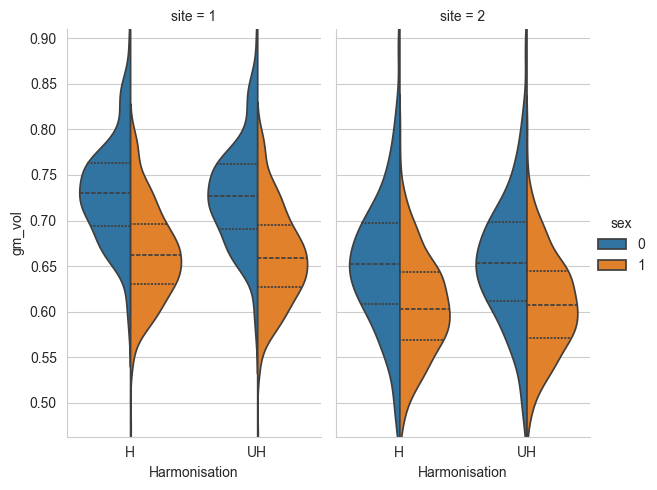

In [36]:
feature =features.value
y_axis = feature
viz_data = complete_harmonised_nonharmonised_merged
#y_axis = "totalgm_b_cov"
sns.set_style("whitegrid")
sns.catplot(data = complete_harmonised_nonharmonised_merged, x = 'Harmonisation', y = y_axis, hue ="sex", 
split=True, inner = 'quartile', kind = 'violin', 
col = 'site', height = 5, aspect = 0.6)
plt.ylim((viz_data[y_axis].min(),viz_data[y_axis].max()))
plt.show()

<!-- # split dataframe back up into parts for running
## from complete_harmonised -->